In [101]:
import random

import cv2
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.morphology
import skimage.util

In [102]:
sns.set(style='dark')
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['image.cmap'] = 'viridis'
np.set_printoptions(threshold=20, edgeitems=10, linewidth=140, precision=3, suppress=True)

# Thresholding

In [103]:
coins_rgb = cv2.imread('data/mince.bmp')[..., ::-1]
coins_gray = cv2.cvtColor(coins_rgb, cv2.COLOR_RGB2GRAY)

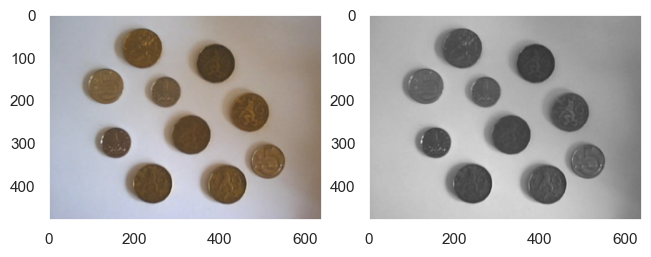

In [104]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(coins_rgb)
axes[1].imshow(coins_gray, cmap='gray', vmin=0, vmax=255);

In [105]:
coins_bw = coins_gray < 100  # dark is foreground, bright is background
coins_bw = 255 * np.uint8(coins_bw)  # cast to something other than boolean for OpenCV and matplotlib imshow
coins_bw.shape, coins_bw.dtype

((480, 640), dtype('uint8'))

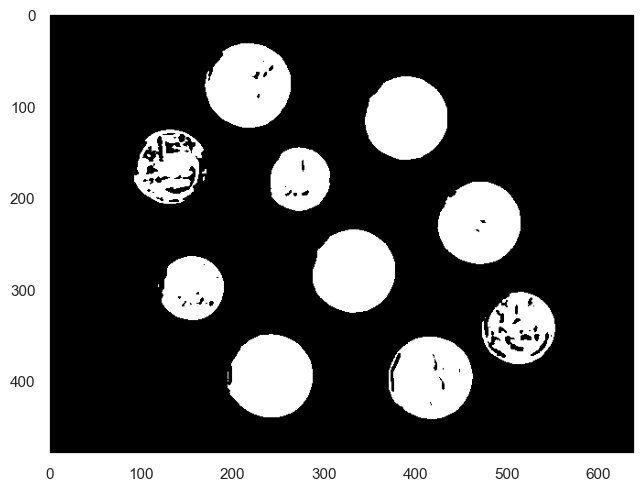

In [106]:
plt.imshow(coins_bw, cmap='gray');

In [107]:
@ipywidgets.interact
def threshold_coins(threshold_value=(0, 255, 1)):
    thr = 255 * np.uint8(coins_gray < threshold_value)
    return plt.imshow(thr, cmap='gray', vmin=0, vmax=255)

interactive(children=(IntSlider(value=127, description='threshold_value', max=255), Output()), _dom_classes=('…

# Otsu thresholding: automatic threshold selection

- Previsouly, we hand-picked the threshold (e.g. value of 100) by trial and error with manual and subjective evaluation of segmentation quality.
- We can create an objective criterion and automate the threshold selection using Otsu's method.

Summary of the method can be found on
- [Wikipedia](https://en.wikipedia.org/wiki/Otsu%27s_method)
- [OpenCV documentation](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)

As a first step, let's blur the image a little bit to filter out noise.

In [108]:
coins_gray_blr = cv2.GaussianBlur(coins_gray, (5, 5), 1)

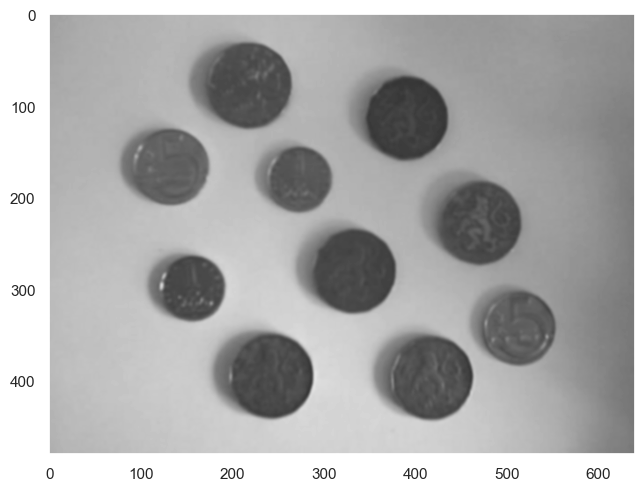

In [109]:
plt.imshow(coins_gray_blr, cmap='gray', vmin=0, vmax=255);

 Otsu's threshold selection works by exhaustively trying each possible threshold and evaluating how well it separates background from foreground. It doesn't actually threshold the image itself, as this could be inefficient e.g. for large images, but rather looks at the pixel brightness distribution of the resulting background and foreground classes. For that, we need the image histogram $h(v)$ for $v=0,\ldots,255$. We will normalize the histogram such that the values sum to one, as we'd like to treat it as a probability mass function (PMF).

In [110]:
coins_hist, coins_bins = np.histogram(coins_gray_blr.ravel(), bins=np.arange(257))
coins_hist = coins_hist.ravel() / coins_hist.sum()  # make it PMF

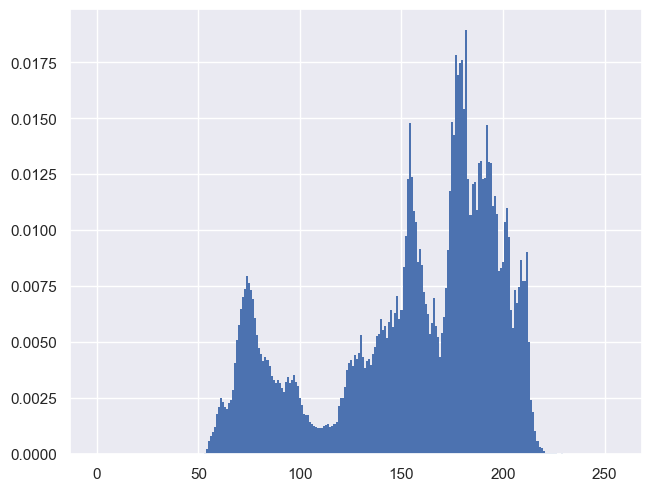

In [111]:
with sns.axes_style('darkgrid'):
    plt.bar(coins_bins[:256], coins_hist, width=1., edgecolor='none');

**Summary of the algorithm**

- We can view thresholding as a classification of pixels into foreground (1) vs background (0), i.e.
  $$
  I_t'(x,y) = \begin{cases}
    1 & \textrm{if} \quad I(x,y) \ge t \\
    0 & \textrm{if} \quad I(x,y) \lt t
  \end{cases}
  $$
  where $t \in \{0,\ldots,255\}$ is some deciding threshold value.
- The number (proportion) of pixels $w_0(t)$ and $w_1(t)$ assigned to the *background* class and *foreground* class, respectively, by the threshold $t$ can be determined from the histogram $h$ as
$$
w_0(t) = \sum_{v=0}^{t-1}h(v) \qquad\qquad w_1(t) = \sum_{v=t}^{255}h(v)
$$
- We now basically have two probability mass functions (PMF):
  1. background pixels with $v = I(x,y) \lt t$ follow $v \sim p_0(v) = h(v) / w_0(t)$
  2. foreground pixels with $v = I(x,y) \ge t$ follow $v \sim p_1(v) = h(v) / w_1(t)$
  - We divide each classes portion of the $h$ by its number of pixels $w_{\{0, 1\}}$ to make sure that both $p_0$ and $p_1$ sum to one and thus constitute PMF
- Now, we can compute expected values (average) $\mu_0$ and $\mu_1$ and variances $\sigma_0^2$ and $\sigma_1^2$ of the *background* and *foreground* classes, respectively
$$
\begin{align*}
  \mu_0(t) & = \sum_{v=0}^{t-1}{v \cdot \frac{h(v)}{w_0(t)}} \qquad\qquad & \mu_1(t) & = \sum_{v=t}^{255}{v \cdot \frac{h(v)}{w_1(t)}} \\
  \sigma_0^2(t) & = \sum_{v=0}^{t-1}{(v - \mu_0(t))^2 \cdot \frac{h(v)}{w_0(t)}} \qquad\qquad & \sigma_1^2(t) & = \sum_{v=t}^{255}{(v - \mu_1(t))^2 \cdot \frac{h(v)}{w_1(t)}} \\
\end{align*}
$$
- We want PMFs of the background $p_0$ and foreground $p_1$ classes to have small variances $\sigma_0^2$ and $\sigma_1^2$, respectively, since that means that pixels we assigned to background all have similar brightnesses and all pixels we assigned to foreground also have similar brightnesses.
- Otsu's method suggests to measure this as the **within-class (intra-class) variance** $\sigma_w^2$
$$
\sigma_w^2(t) = w_0(t) \cdot \sigma_0^2(t) + w_1(t) \cdot \sigma_0^2(t)
$$
- The within-class variance $\sigma_w^2(t)$ will be *smallest* when the threshold $t$ optimally separates background from foreground. 
- Equivalently, we could also want the means $\mu_0$ and $\mu_1$ to be as far apart as they can. To this end, we can compute **between-class (inter-class) variance** $\sigma_b^2$
$$
\sigma_b^2(t) = w_0(t) \cdot w_1(t) \cdot \left(\mu_0(t) - \mu_1(t) \right)^2
$$
- We will compute $\sigma_w^2(t)$ and/or $\sigma_b^2(t)$ for each $t = 1, \ldots, 255$. Our desired optimal threshold $t^*$ is the one that
  - *minimizes*, i.e. makes the $\sigma_w^2(t^*)$ smallest, i.e. $t^* = \argmin_{t}{\sigma_w^2(t)}$
  - *maximizes*, i.e. makes the $\sigma_b^2(t^*)$ largest, i.e. $t^* = \argmax_{t}{\sigma_b^2(t)}$

In [112]:
def threshold_otsu(hist: np.ndarray, method: str = 'within_var_min'):
    # initialization
    if method == 'within_var_min':
        var = np.inf * np.ones(255)
    elif method == 'between_var_max':
        var = np.zeros(255)
    else:
        raise ValueError

    # exhaustively for each possible threshold
    for t in range(1, 255):
        # sums of background and foreground pixels proportions
        w0 = hist[:t].sum()
        w1 = hist[t:].sum()
        
        # prevent division by zero
        if w0 < 1e-5 or w1 < 1e-5:
            continue
        
        # calculate the means
        m0 = np.sum(np.arange(t) * hist[:t]) / w0
        m1 = np.sum(np.arange(t, 256) * hist[t:]) / w1
        
        # variances
        v0 = np.sum(hist[:t] * (np.arange(t) - m0) ** 2) / w0
        v1 = np.sum(hist[t:] * (np.arange(t, 256) - m1) ** 2) / w1
        
        if method == 'within_var_min':
            var[t] = w0 * v0 + w1 * v1  # intra-class variance
        elif method == 'between_var_max':
            var[t] = w0 * w1 * (m0 - m1) ** 2  # inter-class variance
    
    thr = var.argmin() if method == 'within_var_min' else var.argmax()
    return thr, var

In [113]:
thr_within, var_within = threshold_otsu(coins_hist, method='within_var_min')
thr_between, var_between = threshold_otsu(coins_hist, method='between_var_max')
thr_within, thr_between  # should be the same

(136, 136)

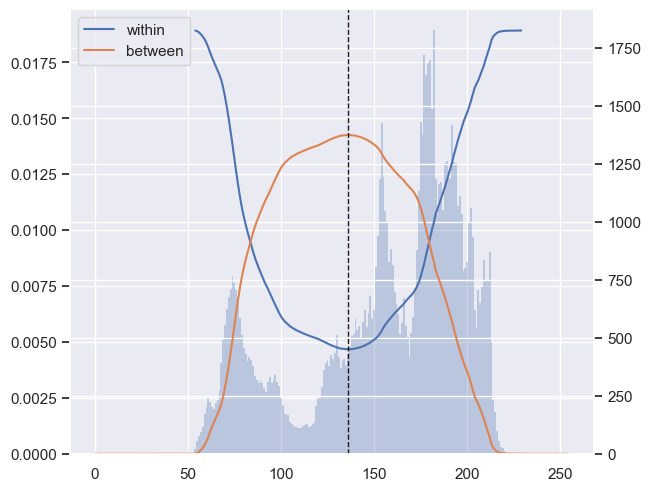

In [114]:
with sns.axes_style('darkgrid'):
    plt.bar(coins_bins[:256], coins_hist, width=1., edgecolor='none', alpha=0.3);
    plt.gca().twinx()
    plt.plot(var_within, label='within');
    plt.plot(var_between, label='between');
    plt.ylim(bottom=0)
    plt.axvline(x=thr_within, linestyle='--', linewidth=1, color='k')
    plt.legend();

In [115]:
# threhold using automatically selected value
coins_bw = 255 * np.uint8(coins_gray < thr_within)

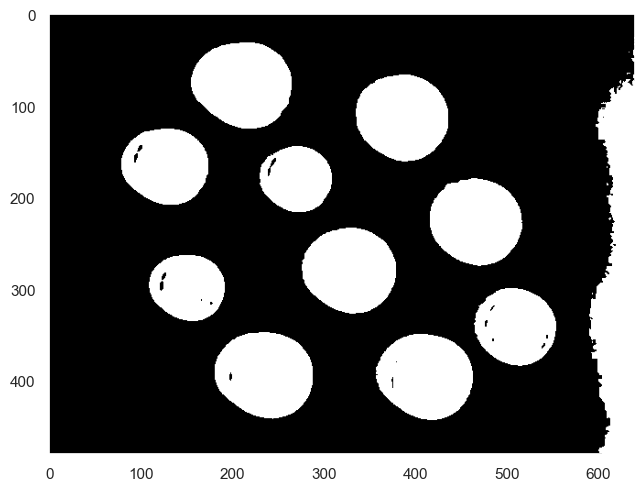

In [116]:
plt.imshow(coins_bw, cmap='gray', vmin=0, vmax=255);

## Otsu's thresholding in scikit-image

In [117]:
thr_otsu_ski = skimage.filters.threshold_otsu(coins_gray)
thr_otsu_ski

135

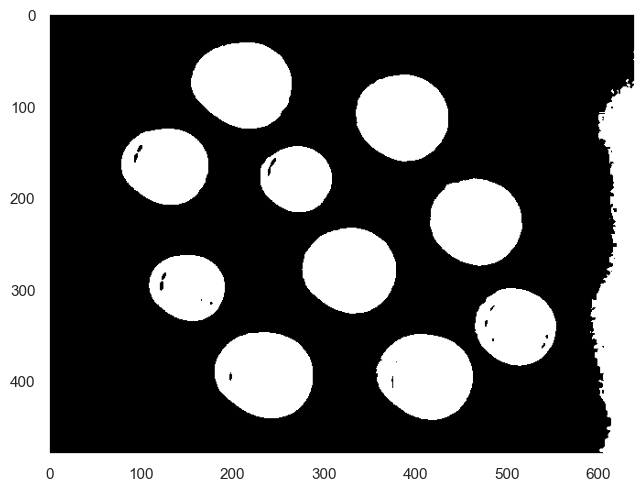

In [118]:
plt.imshow(coins_gray < thr_otsu_ski, cmap='gray', vmin=0, vmax=1);

## Otsu's thresholding in OpenCV

In [119]:
# since we have bright objects on dark background, we need cv2.THRESH_BINARY_INV
thr_otsu_cv, coins_bw = cv2.threshold(coins_gray_blr, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
thr_otsu_cv

135.0

In [120]:
coins_bw.dtype, coins_bw.min(), coins_bw.max()

(dtype('uint8'), 0, 255)

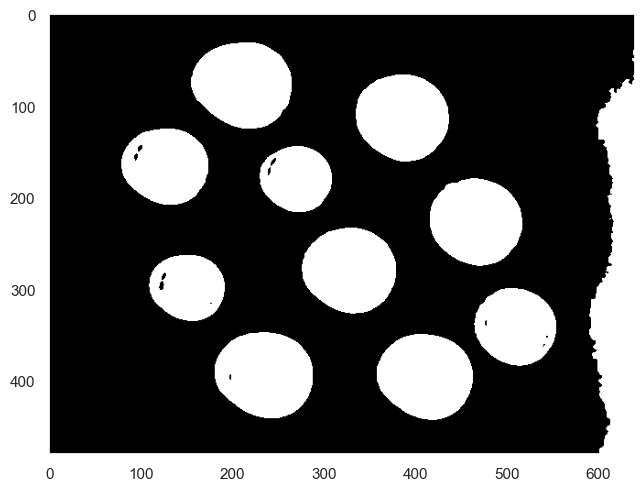

In [121]:
plt.imshow(coins_bw, cmap='gray', vmin=0, vmax=255);

# Non-uniform background: Adaptive thresholding

In [122]:
rice_rgb = cv2.imread('data/rice.bmp')[..., ::-1]
rice_gray = cv2.cvtColor(rice_rgb, cv2.COLOR_RGB2GRAY)

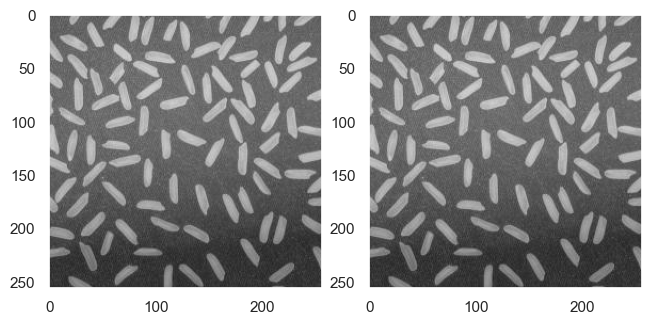

In [123]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(rice_rgb)
axes[1].imshow(rice_gray, cmap='gray', vmin=0, vmax=255);

Lightning is non-uniform to the extent that rice grains in the bottom part of the image are actually darker than background in the upper part, and so it's impossible to threshold the image using single threshold value.

In [124]:
@ipywidgets.interact
def threshold_rice(threshold_value=(0, 255, 1)):
    thr = 255 * np.uint8(rice_gray >= threshold_value)
    return plt.imshow(thr, cmap='gray', vmin=0, vmax=255)

interactive(children=(IntSlider(value=127, description='threshold_value', max=255), Output()), _dom_classes=('…

Adaptive thresholding uses *different threshold value for each pixel $I(x,y)$*. It looks at some neighborhood of $(x,y)$, calculates the average value $\mu_{x,y}$ and then assigns the pixel $x,y$ as:
- foreground, if $I(x,y) \ge \mu_{x,y} + C$
- background, if $I(x,y) \lt \mu_{x,y} + C$ (otherwise)

where $C$ is some user-specified constant.

In [125]:
# args:
# img, value_of_foreground, method, wether_bg_should_be_1_or_0, window_size, C
rice_bw_ada_mean = cv2.adaptiveThreshold(rice_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 151, 0)

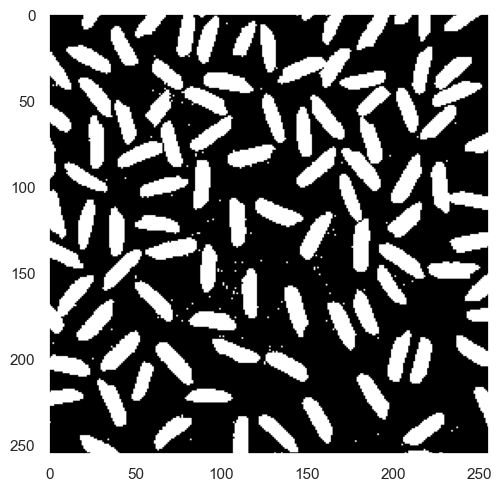

In [126]:
plt.imshow(rice_bw_ada_mean, cmap='gray', vmin=0, vmax=255);

In [127]:
@ipywidgets.interact
def ada_mean_threshold_rice(window_size=(3, 241, 2), c=(-50, 50, 1)):
    thr = cv2.adaptiveThreshold(rice_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, window_size, c)
    return plt.imshow(thr, cmap='gray', vmin=0, vmax=255)

interactive(children=(IntSlider(value=121, description='window_size', max=241, min=3, step=2), IntSlider(value…

In [128]:
rice_bw_ada_gauss = cv2.adaptiveThreshold(rice_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 91, -15)

In [129]:
@ipywidgets.interact
def ada_mean_threshold_rice(window_size=(3, 241, 2), c=(-50, 50, 1)):
    # different method - gaussian weighted average 
    thr = cv2.adaptiveThreshold(rice_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, window_size, c)
    return plt.imshow(thr, cmap='gray', vmin=0, vmax=255)

interactive(children=(IntSlider(value=121, description='window_size', max=241, min=3, step=2), IntSlider(value…

# Binary morphology

In [130]:
def imshow_bw(bw: np.ndarray, origin: tuple[int, int] = None, ax: plt.matplotlib.axes.Axes = None):
    if ax is None:
        ax = plt.gca()
    h, w = bw.shape
    ox, oy = (h // 2, w // 2) if origin is None else origin
    y, x = 0.5 + np.mgrid[:h, :w]
    mask = bw > 0
    p, = ax.plot(x[mask], y[mask], 'o', markersize=20)
    if origin is not None:
        ax.plot(0.5 + origin[0], 0.5 + origin[1], 'o', markersize=30, mfc='none')
    ax.invert_yaxis();
    ax.axis('scaled');
    ax.set_xticks(np.arange(w + 1))
    ax.set_yticks(np.arange(h + 1))
    ax.grid()
    # ax.add_artist(plt.Rectangle(origin, 1., 1., fc='none', ec=p.get_color(), linewidth=2))

## Binary dilation

Dilation operation can be treated as *local maximum* with flipped sctructuring element.

In [131]:
# toy input binary image X
Xd = np.array(
    [
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 1, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
    ],
    dtype=np.uint8
)

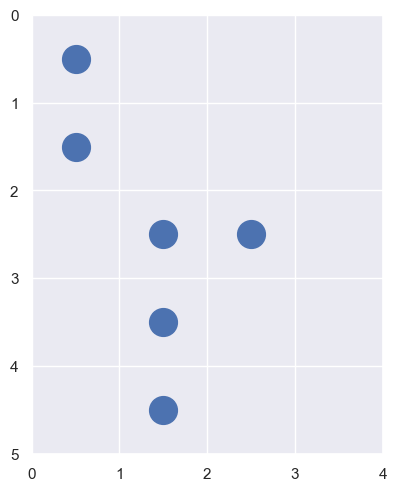

In [132]:
imshow_bw(Xd)

In [133]:
# structuring element B
# mind the double brackets, B must be 2D
Bd = np.array(
    [
        [1, 1]
    ],
    dtype=np.uint8
)

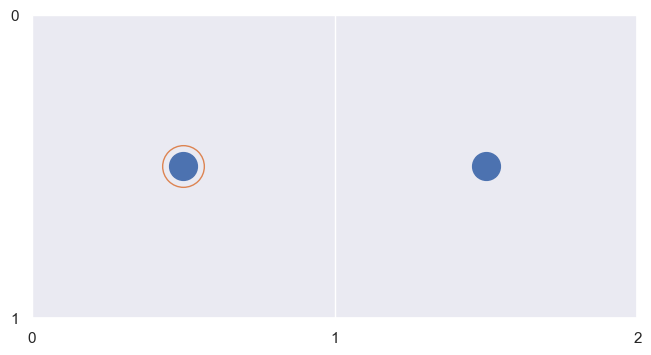

In [134]:
imshow_bw(Bd, origin=(0, 0))

### OpenCV binary dilation

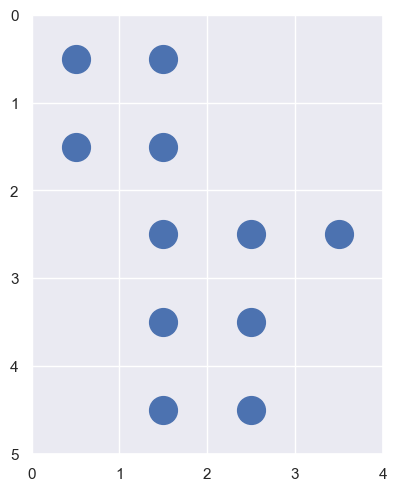

In [135]:
# perform binary dilation
imshow_bw(cv2.morphologyEx(Xd, cv2.MORPH_DILATE, Bd))

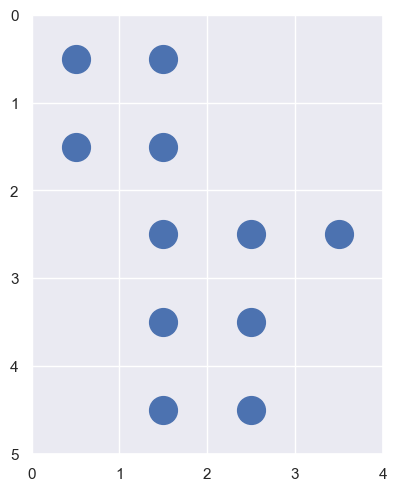

In [136]:
# we can also explicitly specify the anchor point (1, 0) and border conditions
imshow_bw(cv2.morphologyEx(Xd, cv2.MORPH_DILATE, Bd, None, (1, 0), 1, cv2.BORDER_CONSTANT, 0))

### scikit-image binary dilation

The dilation operation also exists in the [scikit-image](https://scikit-image.org/) library. It doesn't flip the structuring element and doesn't allow specifying the anchor point manually either, however, so the result is kind of shifted by one to the left in this case.

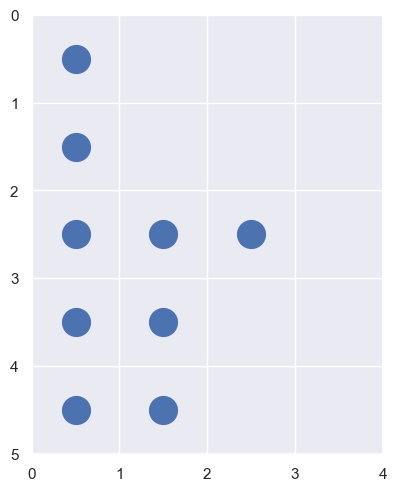

In [137]:
imshow_bw(skimage.morphology.binary_dilation(Xd, Bd).astype(np.uint8))

Workaround: pad the input with zeros from the left and then throw away the last column of the result.

In [138]:
# pad the image with zeroes
Xp = np.pad(Xd, ((0, 0), (1, 0)), 'constant')
Xp

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

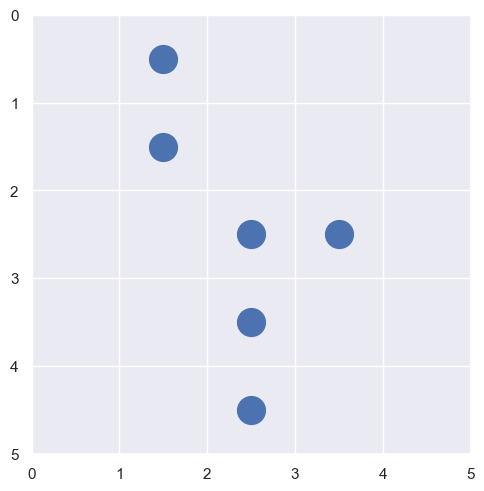

In [139]:
imshow_bw(Xp)

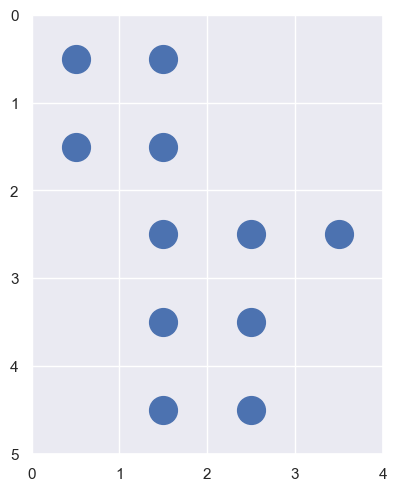

In [140]:
imshow_bw(skimage.morphology.binary_dilation(Xp, Bd).astype(np.uint8)[:, :-1])

### OpenCV dilation applied to the coins image

In order to fill up the holes in coins, we need sufficiently large structuring element. OpenCV provides function `getStructuringElement`, where we can specify shape and size we want and the function will return the desired structuring element.

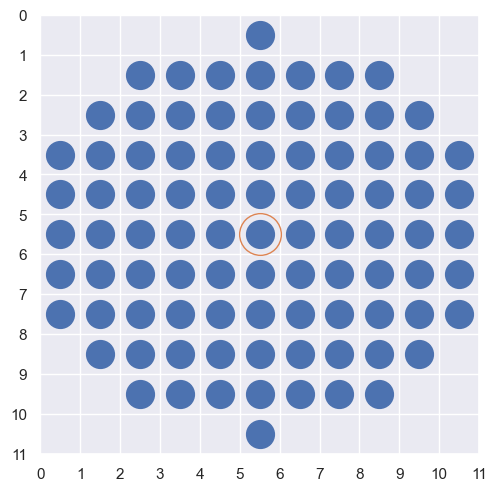

In [141]:
imshow_bw(cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11)), origin=(5, 5))

In [142]:
coins_dilated = cv2.morphologyEx(
    coins_bw,
    cv2.MORPH_DILATE,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11)),
    None,
    (-1, -1),
    1,
    cv2.BORDER_CONSTANT,
    0
)

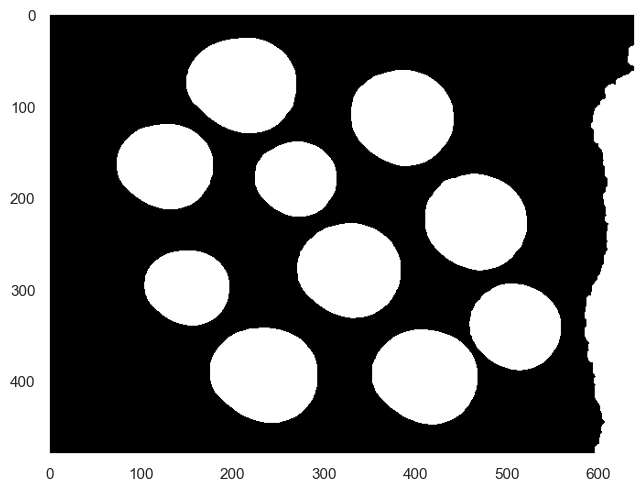

In [143]:
plt.imshow(coins_dilated, cmap='gray');

## Binary erosion

Erosion operation corresponds to finding *local minimum* without flipping the structuring element.

In [144]:
# toy input binary image
Xe = np.array(
    [
        [0, 1, 0, 0],
        [1, 1, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
    ],
    dtype=np.uint8
)

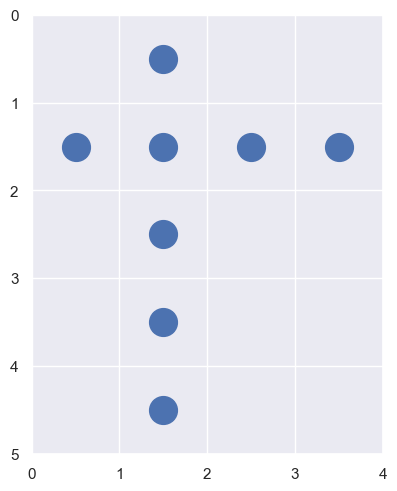

In [145]:
imshow_bw(Xe)

In [146]:
# structuring element
Be = np.array(
    [
        [1, 1]
    ],
    dtype=np.uint8
)

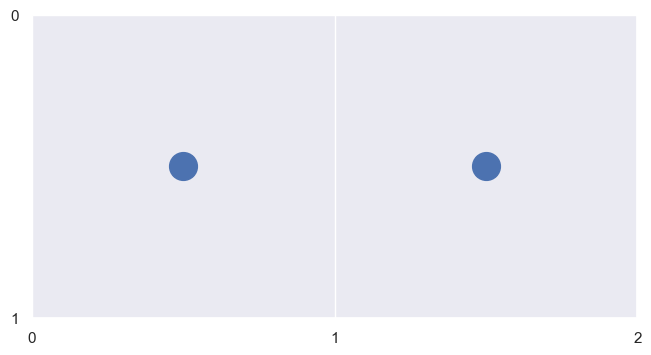

In [147]:
imshow_bw(Be)

### OpenCV erosion

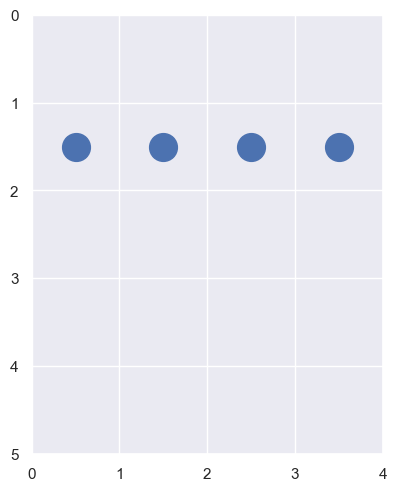

In [148]:
imshow_bw(cv2.morphologyEx(Xe, cv2.MORPH_ERODE, Be))

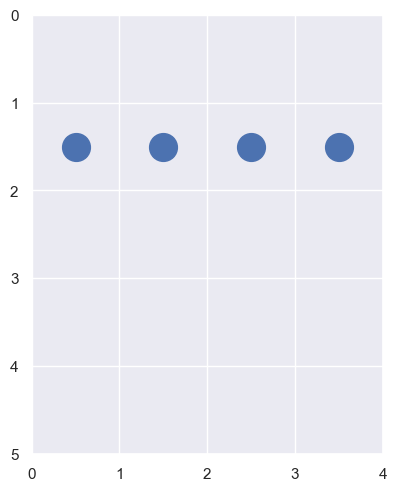

In [149]:
imshow_bw(cv2.morphologyEx(Xe, cv2.MORPH_ERODE, Be, None, (1, 0), 1, cv2.BORDER_CONSTANT, 1))

### scikit-image erosion

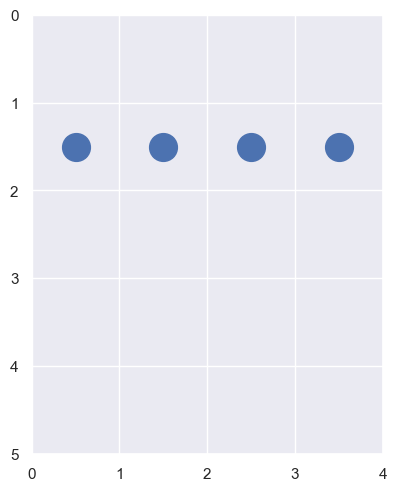

In [150]:
# works, because there's no flipping in erosion
imshow_bw(skimage.morphology.binary_erosion(Xe, Be).astype(np.uint8))

### OpenCV erosion applied to the *dilated* coins image

Using dilation, we filled up the holes, but the coins also grew in size. Now, using erosion, we can "shrink" the coins back to their original size with the holes still being gone.

In [151]:
coins_dilated_eroded = cv2.morphologyEx(
    coins_dilated,
    cv2.MORPH_ERODE,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11)),  # we're using the same structuring element
    None,
    (1, 0),
    1,
    cv2.BORDER_CONSTANT,
    0
)

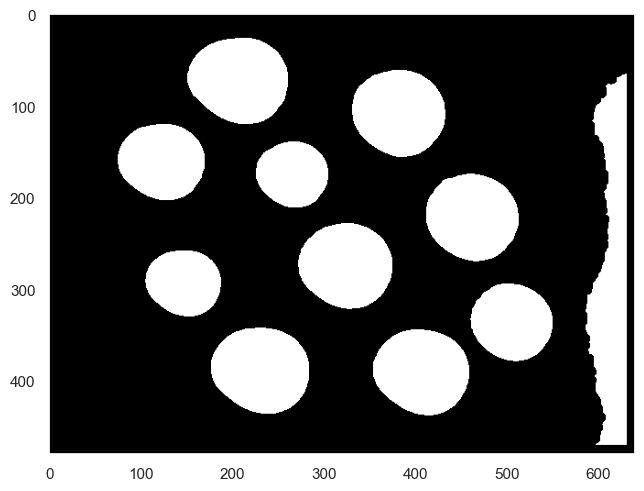

In [152]:
plt.imshow(coins_dilated_eroded, cmap='gray');

### OpenCV erosion applied to the rice grains image

Using erosion, we can get rid of small objects that basically only are noise in the rice image.

In [153]:
rice_eroded = cv2.morphologyEx(
    rice_bw_ada_gauss,
    cv2.MORPH_ERODE,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)),
    None,
    (1, 0),
    1,
    cv2.BORDER_CONSTANT,
    0
)

In [154]:
# grow back to original size using dilation
rice_eroded_dilated = cv2.morphologyEx(
    rice_eroded,
    cv2.MORPH_DILATE,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)),
    None,
    (1, 0),
    1,
    cv2.BORDER_CONSTANT,
    0
)

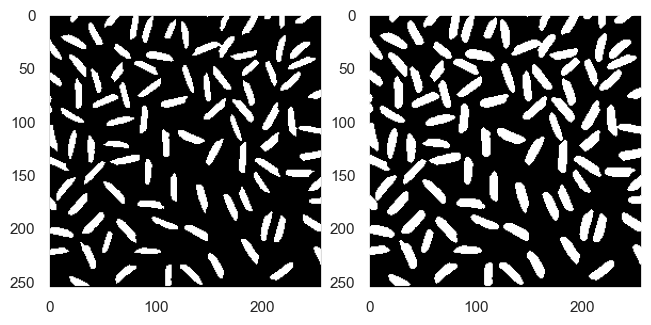

In [155]:
plt.subplot(1, 2, 1)
plt.imshow(rice_eroded, cmap='gray', vmin=0, vmax=255);
plt.subplot(1, 2, 2)
plt.imshow(rice_eroded_dilated, cmap='gray', vmin=0, vmax=255);

## Binary closing

Morphological dilation followed by erosion using the same structuring element is called *closing*.

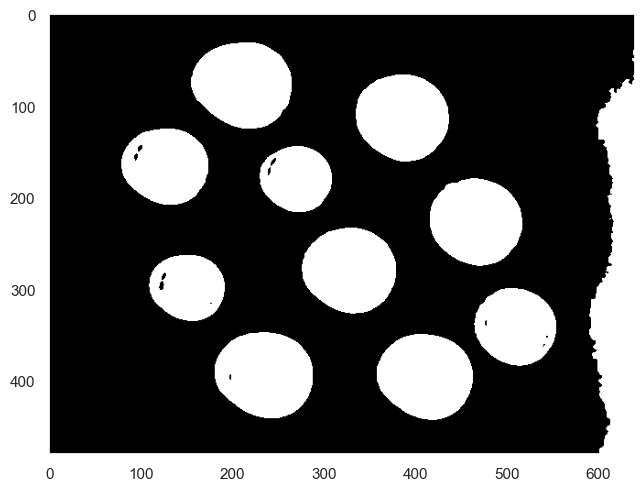

In [156]:
# original thresholded image
plt.imshow(coins_bw, cmap='gray');

In [157]:
# again, the same structuring element; should be big enough to cover the holes, but not too big
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
strel

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=uint8)

In [158]:
# closing is dilation followed by erosion
coins_closed_ = cv2.morphologyEx(coins_bw, cv2.MORPH_DILATE, strel)
coins_closed_ = cv2.morphologyEx(coins_closed_, cv2.MORPH_ERODE, strel)

In [159]:
# OpenCV knows closing as one of the basic morphological operations
coins_closed = cv2.morphologyEx(coins_bw, cv2.MORPH_CLOSE, strel)

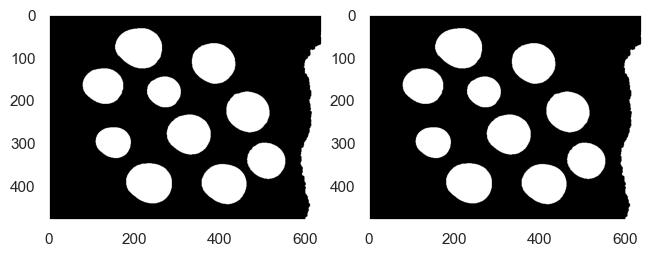

In [160]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(coins_closed_, cmap='gray', vmin=0, vmax=255);
axes[1].imshow(coins_closed, cmap='gray', vmin=0, vmax=255);

In [161]:
# verify dilating then eroding is the same as closing
np.sum(coins_closed_ != coins_closed_)

0

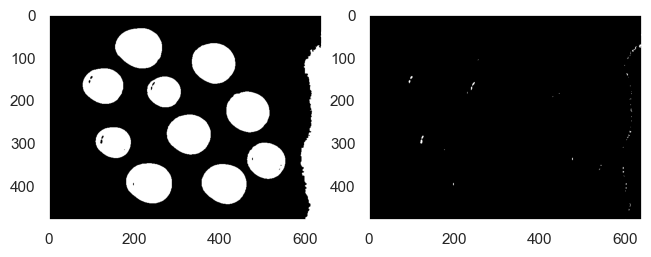

In [162]:
# show differences from the original thresholded image
fig, axes = plt.subplots(1, 2)
axes[0].imshow(coins_bw, cmap='gray')
axes[1].imshow(np.abs(coins_bw - coins_closed), cmap='gray');

## Binary opening

Morphological opening is erosion followed by dilation.

In [163]:
rice_opened = cv2.morphologyEx(
    rice_bw_ada_gauss,
    cv2.MORPH_OPEN,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
)

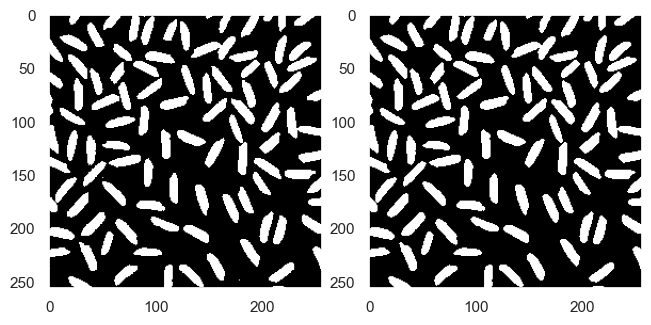

In [164]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(rice_bw_ada_gauss, cmap='gray');
axes[1].imshow(rice_opened, cmap='gray');

# Grayscale morphology

Dilation and erosion as local maximum and local minimu, respectively, work on grayscale images too. They can be used to filter out "spiky" noise like salt and pepper for example.

In [165]:
coins_gray_sp = skimage.util.random_noise(coins_gray, mode='s&p', amount=0.05)

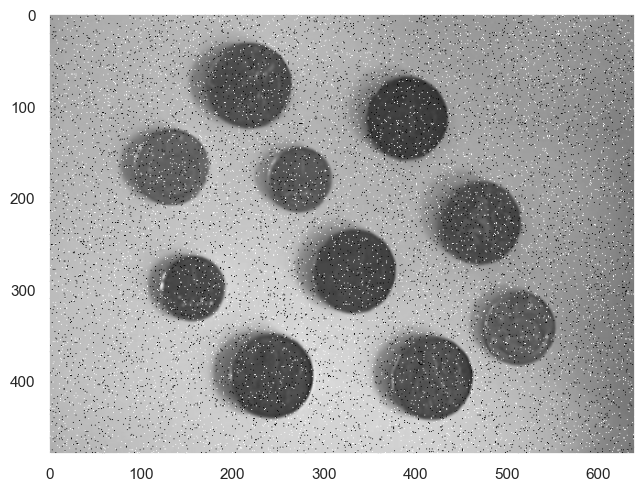

In [166]:
plt.imshow(coins_gray_sp, cmap='gray', vmin=0, vmax=1);

The noise manifests as single pixel large black (pepper) or white (salt) objects. Therefore, we only need very small structuring element.

In [167]:
sp_selem = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
sp_selem

array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)

In [168]:
# bad structing element
sp_selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

Closing, a.k.a dilation followed by erosion, will remove "dips" in brightness, i.e. black pixels (pepper). Erosion will remove brightness "peaks", i.e. white pixels (salt).

In [169]:
coins_gray_sp_closed = cv2.morphologyEx(coins_gray_sp, cv2.MORPH_CLOSE, sp_selem)
coins_gray_sp_closed_opened = cv2.morphologyEx(coins_gray_sp_closed, cv2.MORPH_OPEN, sp_selem)

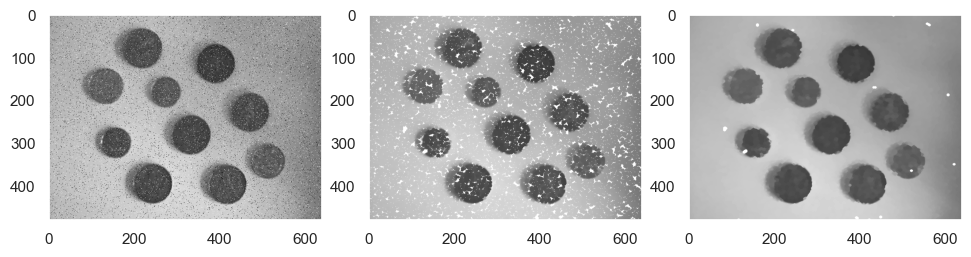

In [170]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.5))
axes[0].imshow(coins_gray_sp, cmap='gray', vmin=0, vmax=1)
axes[1].imshow(coins_gray_sp_closed, cmap='gray', vmin=0, vmax=1)
axes[2].imshow(coins_gray_sp_closed_opened, cmap='gray', vmin=0, vmax=1);

Just for fun, compare the morphological filtering against median smoothing.

In [171]:
coins_gray_sp_med = cv2.medianBlur((255 * coins_gray_sp).astype(np.uint8), 3)

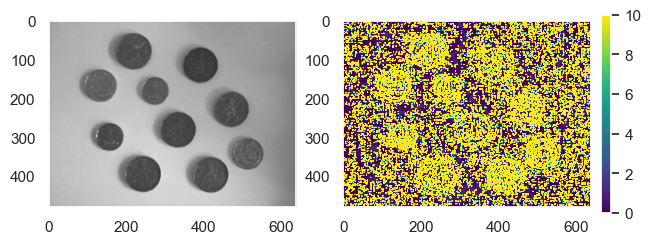

In [172]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(coins_gray_sp_med, cmap='gray', vmin=0, vmax=255)
im = axes[1].imshow(np.abs(coins_gray - coins_gray_sp_med), vmin=0, vmax=10)
fig.colorbar(im, fraction=0.04, pad=0.04);

# Region labeling (grayscale images)

We can label each group of connected pixels (a.k.a. object) with a unique label using function [skimage.measure.label](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label).

In [173]:
rice_label_image = skimage.measure.label(rice_opened)

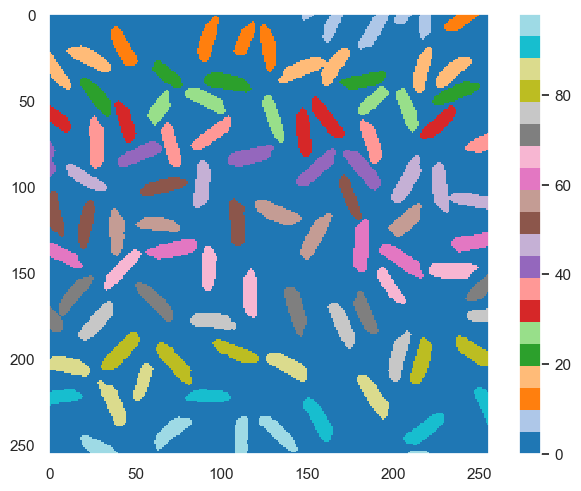

In [174]:
plt.imshow(rice_label_image, cmap='tab20', interpolation='none')
plt.colorbar();

In [175]:
np.unique(rice_label_image)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, ..., 89, 90, 91, 92, 93, 94, 95, 96, 97, 98], dtype=int64)

We can also get additional information about every object using function [skimage.measure.regionprops](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops).

In [176]:
rice_reg_props = skimage.measure.regionprops(rice_label_image)
type(rice_reg_props), len(rice_reg_props)

(list, 98)

In [177]:
rice_reg_props[0]

We now have a list of 98 `RegionProperties` objects and each one has lots of useful information. For example, we can get the bounding box of each object as its `bbox` attribute, which is a quadruple of `y1, x1, y2, x2`.

We can also get all the pixels belonging to that particular object using `coords` attribute, which is a `numpy.ndarray` with shape of `(num_points, 2)` of `(y, x)` pairs for each pixel of the object.

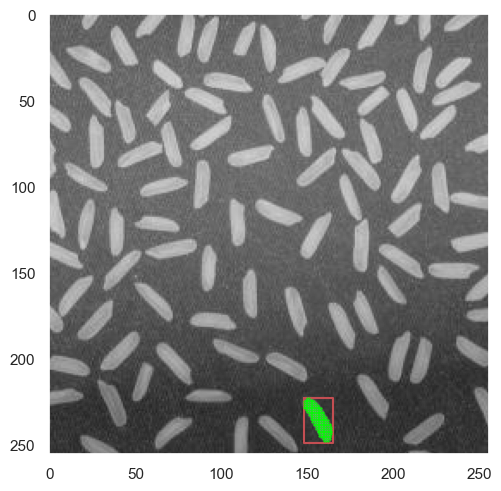

In [178]:
# run this cell repeatedly

# pick some object randomly
rp = random.choice(rice_reg_props)
y1, x1, y2, x2 = rp.bbox  # bounding box

plt.imshow(rice_gray, cmap='gray', vmin=0, vmax=255)
plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], '-r')  # draw bounding box
plt.plot(rp.coords[:, 1], rp.coords[:, 0], '.', color=(0, 1, 0), markersize=1);  # mark each pixel of the region (object) with green color
# plt.axis('off');

In [179]:
# there are lots of useful properties, e.g. area or coords
rp.area, rp.coords.shape, rp.coords.dtype

(218.0, (218, 2), dtype('int64'))

# OpenCV `connectedComponents(withStats)` (only binary images)

The function [`cv2.connectedComponentsWithStats`](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gae57b028a2b2ca327227c2399a9d53241) combines functionality of `skimage.measure.label` and `skimage.measure.regionprops`. It will give us
- `ret`, which is the number of objects
- `markers`, which is the same as `label_image` of `skimage.measure.label`
- `stats`, which is a `numpy.ndarray` with 5 columns and $i$-th row being `x, y, w, h, area` of $i$-th object (region)
- `centroids`, which is a `numpy.ndarray` with 2 columns and $i$-th row being the $x_c,y_c$ coordinate of the $i$-th object's center of gravity

In [180]:
ret, rice_markers, rice_comp_stats, rice_comp_centroids = cv2.connectedComponentsWithStats(rice_opened)
ret

99

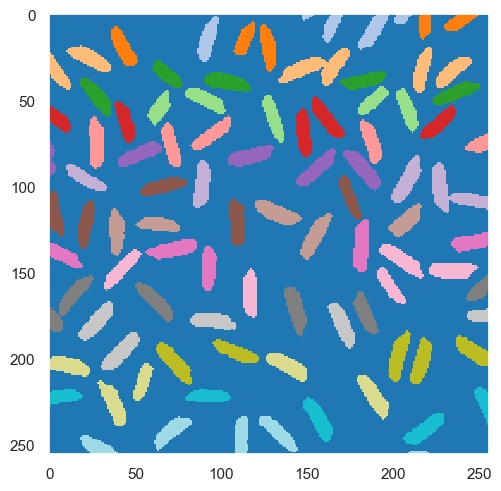

In [181]:
plt.imshow(rice_markers + 1, cmap='tab20', interpolation='none');

In [182]:
ret, np.unique(rice_markers)

(99,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, ..., 89, 90, 91, 92, 93, 94, 95, 96, 97, 98], dtype=int32))

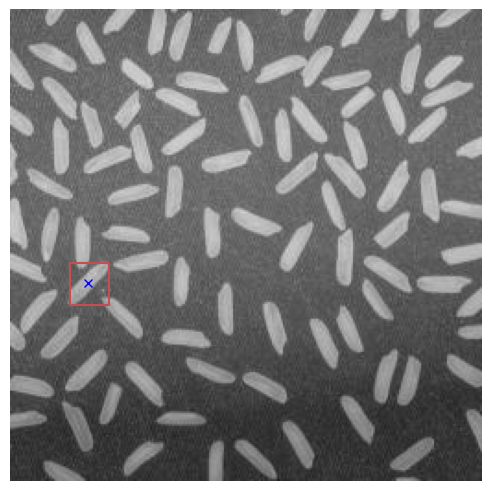

In [183]:
# run this cell repeatedly

i = random.choice(range(len(rice_comp_stats)))
x, y, w, h, area = rice_comp_stats[i, :]
xc, yc = rice_comp_centroids[i, :]

plt.imshow(rice_gray, cmap='gray', vmin=0, vmax=255)
plt.plot([x, x+w-1, x+w-1, x, x], [y, y, y+h-1, y+h-1, y], '-r')
plt.plot([xc], [yc], 'x', color=(0, 0, 1))
plt.axis('off');

# OpenCV `findContours` (only binary images)

Examples:
- Introduction: https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html
- Contour features: https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
- Contour properties: https://docs.opencv.org/3.4/d1/d32/tutorial_py_contour_properties.html

In [184]:
rice_contours, rice_hierarchy = cv2.findContours(rice_bw_ada_gauss, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

In [185]:
type(rice_contours), len(rice_contours)

(tuple, 102)

What hierarchy means can be found here:  
https://docs.opencv.org/3.4/d9/d8b/tutorial_py_contours_hierarchy.html

In [186]:
rice_hierarchy.dtype, rice_hierarchy.shape

(dtype('int32'), (1, 102, 4))

In [187]:
counts = [len(c) for c in rice_contours]
rice_contours[1]

array([[[178, 248]]], dtype=int32)

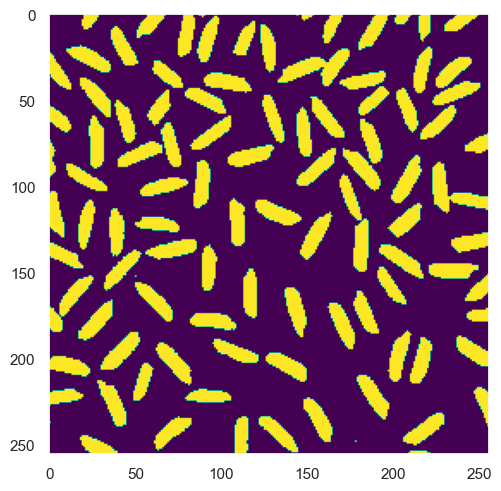

In [188]:
plt.imshow(rice_bw_ada_gauss)

(-0.5, 255.5, 255.5, -0.5)

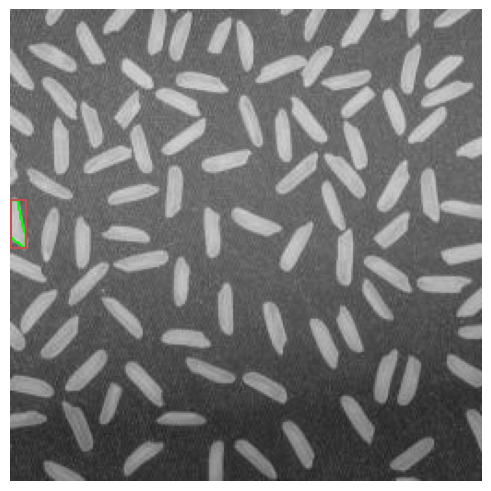

In [189]:
i = random.choice(range(len(rice_contours)))
ctr = rice_contours[i].squeeze()  #.astype(np.float32)  # depending on the OpenCV version
x, y, w, h = cv2.boundingRect(ctr)

plt.imshow(rice_gray, cmap='gray', vmin=0, vmax=255)
plt.plot(ctr[:, 0], ctr[:, 1], color=(0, 1, 0))
plt.plot([x, x+w-1, x+w-1, x, x], [y, y, y+h-1, y+h-1, y], '-r')
plt.axis('off')

# Corners of sudoku using `findContours`

Simplified excerpt of the method described here:  
[https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2](https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2)

In [190]:
sudoku_rgb = cv2.imread('data/sudokubig.jpg')[..., ::-1]
sudoku_gray = cv2.cvtColor(sudoku_rgb, cv2.COLOR_RGB2GRAY)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(sudoku_rgb)
axes[1].imshow(sudoku_gray, cmap='gray', vmin=0, vmax=255);

In [ ]:
sudoku_ada_mean_thresholded = 255 - cv2.adaptiveThreshold(sudoku_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 5)

In [ ]:
plt.imshow(sudoku_ada_mean_thresholded, cmap='gray');

In [ ]:
sudoku_contours, sudoku_hierarchy = cv2.findContours(sudoku_ada_mean_thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
len(sudoku_contours)

In [ ]:
# find the largest contour with respect to its area
idx_largest = max([i for i in range(len(sudoku_contours))], key=lambda i: cv2.contourArea(sudoku_contours[i]))
idx_largest

In [ ]:
plt.imshow(sudoku_rgb)
plt.plot(sudoku_contours[idx_largest][:, 0, 0], sudoku_contours[idx_largest][:, 0, 1], '-r');

In [ ]:
# simplify the contour
# the value 20 is approximation tolerance and is hand-picked such that the result has exactly four vertices
quad = cv2.approxPolyDP(sudoku_contours[idx_largest], 20, True)
quad.shape, quad

In [ ]:
plt.imshow(sudoku_rgb)
plt.plot(sudoku_contours[idx_largest][:, 0, 0], sudoku_contours[idx_largest][:, 0, 1], '-r')  # original contour
plt.plot(quad[:, 0, 0], quad[:, 0, 1], 'o', color=(0, 1, 0));  # approximated contour with 4 vertices